In [1]:
import numpy as np
import numpy.linalg as LA
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import control

import time
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

# Create a new visualizer
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [2]:
from scipy.spatial.transform import Rotation as R

def rotx(a):
    """Rotation matrix about x"""
    return R.from_euler('X', a).as_matrix()

def roty(a):
    """Rotation matrix about y"""
    return R.from_euler('Y', a).as_matrix()

def rotz(a):
    """Rotation matrix about z"""
    return R.from_euler('Z', a).as_matrix()

def dot_2d(v1,v2) -> np.ndarray:
    """For (D,N) vectors, return (N,) dot products
    Compute the dot product along each column (N times)"""
    if v1.ndim == 1 and v2.ndim == 1:
        return np.atleast_1d(np.dot(v1,v2))
    elif v1.ndim == 2 and v2.ndim == 2:
        N = v1.shape[1]
        output = np.zeros(N)
        for i in range(N):
            output[i] = v1[:,i].T @ v2[:,i]
        return output
    else:
        raise ValueError(f"Cannot compute 2d dot product, v1 {v1.shape} and v2 {v2.shape} dimensions do not match")

def apply(M, vec) -> np.ndarray:
    """ Apply a sequence of linear transformations (N,D,D) of length N and size D x D
    to either a vector (D,) or a sequence of vectors (D,N) """
    # Check for the single Rot matrix case (3,3) and return instantly
    if M.ndim < 3:
        return M @ vec
    
    # Apply N rotations to a single vector
    if vec.ndim == 1:
        return M @ vec
        
    # Apply N rotations to N vectors
    elif M.shape[0] == vec.shape[1]:
        N = M.shape[0]
        D = M.shape[1]
        output = np.zeros((D,N))
        for i,R in enumerate(M):
            output[:,i] = R @ vec[:,i]
        return output
    
    # N rotations cannot be applied to M vectors
    else:
        raise ValueError("Cannot apply different number of transformations and vectors")

def hatmap(vec):
    """ Map a (R^3) vector to the SO(3) Lie algebra
    to either a vector (3,) -> (3,3) or a sequence of vectors (3,N) -> (N,3,3) """
    a1 = vec[0].reshape(-1,1,1)
    a2 = vec[1].reshape(-1,1,1)
    a3 = vec[2].reshape(-1,1,1)
    zero = np.zeros_like(a1)
    M = np.block( [[zero, -a3,    a2],
                   [ a3,  zero,  -a1],
                   [-a2,   a1,   zero]] )
    return np.squeeze(M)

# The hatmap is also the skew symmetric matrix
skew = hatmap

def veemap(M):
    """ Map the SO(3) Lie algebra to a (R^3) vector
    Input can be either (3,3) -> (3,) or (N,3,3) -> (3,N) """
    if M.ndim == 2:
        v = np.zeros(3)
        v[0] = M[2,1]
        v[1] = M[0,2]
        v[2] = M[1,0]
    elif M.ndim == 3:
        N = M.shape[0]
        v = np.concatenate([ M[:,2,1].reshape(1,N),
                             M[:,0,2].reshape(1,N),
                             M[:,1,0].reshape(1,N) ])        
    else:
        raise ValueError(f"{M.shape} cannot be interpreted as a SO(3) map")
    return v

def atan2(Y, X) -> np.ndarray:
    """Numpy's arctan2, but output is at least 1D array"""
    return np.atleast_1d(np.arctan2(Y,X))

def asin(X) -> np.ndarray:
    """Numpy's arcsin, but output is at least 1D array"""
    return np.atleast_1d(np.arcsin(X))

def stack_squeeze(arr) -> np.ndarray:
    """Stack along axis 0, then squeeze to remove any trailing dimensions of size 1"""
    return np.squeeze(np.stack( arr ))

# def eul2rotm(eul) -> np.ndarray:
#     """ Rotation matrix from euler angles
#     If input is (3,) return (3,3)
#     If input is (3,N) return (N,3,3) """
#     # Align eul to (3,N)
#     if eul.shape[0] != 3:
#         eul = eul.T
    
#     # Get length N
#     N = eul.shape[1] if eul.ndim > 1 else 1
    
#     # Precompute the sin and cos terms
#     s = []
#     c = []
#     for i in range(3):
#         s.append( np.sin(eul[i]).reshape(-1,1,1) )
#         c.append( np.cos(eul[i]).reshape(-1,1,1) )
    
#     # Form rotation matrix (N,3,3)
#     M = np.block([ [c[2]*c[1], c[2]*s[1]*s[0] - s[2]*c[0], c[2]*s[1]*c[0] + s[2]*s[0]],
#                    [s[2]*c[1], s[2]*s[1]*s[0] + c[2]*c[0], s[2]*s[1]*c[0] - c[2]*s[0]],
#                    [ -s[1],               c[1]*s[0],                  c[1]*c[0]      ] ])
    
#     return np.squeeze(M)

def eul2rotm(eul):
    return R.from_euler('ZYX', eul[::-1].T).as_matrix()

def quat2rotm(quat) -> np.ndarray:
    """Rotation matrix from quaternion
    (4,N) --> (N,3,3) """
    q0 = quat[0].reshape(-1,1,1)
    q1 = quat[1].reshape(-1,1,1)
    q2 = quat[2].reshape(-1,1,1)
    q3 = quat[3].reshape(-1,1,1)
    
    M = np.block([ [ q0**2 + q1**2 - q2**2 - q3**2,
                     2*(q1*q2 - q0*q3),
                     2*(q1*q3 + q0*q2) ], 
                   [ 2*(q1*q2 + q0*q3),
                     q0**2 + q2**2 - q1**2 - q3**2,
                     2*(q2*q3 - q0*q1) ],
                   [ 2*(q1*q3 - q0*q2),
                     2*(q2*q3 + q0*q1),
                     q0**2 + q3**2 - q1**2 - q2**2 ] ])
    
    return np.squeeze(M)

# def quat2eul(quat) -> np.ndarray:
#     """ Euler angles from quaternion
#     (4,N) --> (3,N) """
#     q0 = quat[0]
#     q1 = quat[1]
#     q2 = quat[2]
#     q3 = quat[3]
#     one = np.ones_like(q0)
    
#     phi = atan2( 2*(q0*q1 + q2*q3), one - 2*(q1**2 + q2**2) )
#     theta = asin( 2*(q0*q2 - q3*q1) )
#     psi = atan2( 2*(q0*q3 + q1*q2), one - 2*(q2**2 + q3**3) )
    
#     return np.squeeze(np.stack([phi,theta,psi]))

def quat2eul(quat) -> np.ndarray:
    """ Euler Angles from Quaternion
    (4,N) --> (3,N) """
    # Convert from (w,x,y,z) to (x,y,z,w)
    quat_scipy = np.concatenate([quat[1:4], quat[0:1]])
    eul = R.from_quat(quat_scipy.T).as_euler('ZYX').T
    return np.squeeze(eul[::-1])

def rotm2eul(rotm) -> np.ndarray:
    eul = R.from_matrix(rotm).as_euler('ZYX')
    return np.squeeze(eul[::-1])

**Setup**
1. Multicopter physics
2. Generate trajectories
3. Define control law

In [3]:
class Translation:
    num_states = 6
    x0 = np.zeros(6)
    def __call__(self, params, T, LMN, x):
        # Form thrust vector (in body frame)
        thrust = np.concatenate([0*T, 0*T, -T])

        # Position
        d_pos = x['vel']

        # Velocity
        d_vel = apply(x['eRb'], thrust) / params['mass']
        d_vel[2] += 9.81

        return np.concatenate([d_pos, d_vel])

class EulerRotation:
    num_states = 3
    x0 = np.zeros(6)
    def body_rate_to_euler_dot(self, eul):
        """ Compute the transformation to go from body rates pqr to euler derivative
        for either a vector (3,) -> (3,3) or a sequence of vectors (3,N) -> (N,3,3) """
        # Align eul to (3,N)
        if eul.shape[0] != 3:
            eul = eul.T

        # Get length N
        N = eul.shape[1] if eul.ndim > 1 else 1

        # Precompute the sin and cos terms
        one = np.ones_like(eul[0]).reshape(-1,1,1)
        zero = np.zeros_like(eul[0]).reshape(-1,1,1)
        s2 = np.sin(eul[2]).reshape(-1,1,1)
        c2 = np.cos(eul[2]).reshape(-1,1,1)
        t1 = np.tan(eul[1]).reshape(-1,1,1)
        sec1 = 1 / np.cos(eul[1]).reshape(-1,1,1)

        # Form rotation matrix (N,3,3)
        M = np.block([ [one,  s2*t1,   c2*t1],
                       [zero,   c2,     -s2],
                       [zero, s2*sec1, c2*sec1]
                     ])
        return np.squeeze(M)

    def __call__(self, params, T, LMN, x):
        # Convert body-axis rates pqr to euler derivative
        eul_dot = apply(self.body_rate_to_euler_dot(x['att']), x['rate'])
        
        # Attitude
        d_att = eul_dot

        # Angular Rate
        euler_cross_product = apply(skew(x['rate']) @ params['J'], x['rate'])
        d_rate = 1 / params['J'] * (LMN - euler_cross_product)
        
        return np.concatenate([d_att, d_rate])

class QuaternionRotation:
    num_states = 4
    x0 = np.array([1.,0.,0.,0.,0.,0.,0.])
    def __init__(self, K=0.1):
        # Renormalisation gain
        self.K = K
        
    def make_Omega(self, omega):
        w1 = omega[0].reshape(-1,1,1)
        w2 = omega[1].reshape(-1,1,1)
        w3 = omega[2].reshape(-1,1,1)
        z  = np.zeros_like(w1)
        Omega = np.block([ [z,  -w1, -w2, -w3],
                           [w1,  z,   w3, -w2],
                           [w2, -w3,  z,   w1],
                           [w3,  w2, -w1,  z ] ])
        return np.squeeze(Omega)
        
    def __call__(self, params, T, LMN, x):
        q = x['att']
        
        # Use quaternion derivative formulation of \dot{q} = 0.5 * Omega * q
        Omega = self.make_Omega(x['rate'])
        d_quat = 0.5 * apply(Omega, q)
        
        # Gain to limit norm drift
        c = self.K * (np.ones_like(q) - dot_2d(q,q))
        d_quat += c * q
        
        # Angular Rate
        euler_cross_product = apply(skew(x['rate']) @ params['J'], x['rate'])
        d_rate = 1 / params['J'] * (LMN - euler_cross_product)
        
        return np.concatenate([d_quat, d_rate])
        
class DefaultRotor:
    num_states = 0
    x0 = np.zeros(0)
    def __init__(self, T_max, LMN_max):
        self.T_max = T_max
        self.LMN_max = LMN_max
        
    def __call__(self, params, u, x):
        T = np.atleast_1d(u[0])
        LMN = u[1:4]
        
        # Saturate the Thrust and Torques
        T = np.clip(T, 0, self.T_max)
        LMN = np.clip(LMN, -self.LMN_max, self.LMN_max)
        
        return T, LMN
    
class DefaultAero:
    num_states = 0
    x0 = np.zeros(0)
    def __call__(self, params, u, x):
        d_pos = np.zeros_like(x['pos'])
        d_vel = np.zeros_like(x['vel'])
        d_att = np.zeros_like(x['att'])
        d_rate = np.zeros_like(x['rate'])
        return np.concatenate([d_pos, d_vel, d_att, d_rate])

In [4]:
class Quadcopter(object):
    def __init__(self, rotationType='Euler', Ts=0.01, params=None, reference=None, control=None, rotor=None, aero=None):
        # Assign values, with defaults
        self.reference = reference if reference else DefaultReference
        self.control = control if control else StateFeedbackControl
        self.rotor = rotor if rotor else DefaultRotor(30,1)
        self.aero = aero if aero else DefaultAero()
        self.params = params if params else DefaultParams()
        
        self.translation = Translation()
        # Choose rotational dynamics
        if rotationType == 'Quaternion':
            self.rotation = QuaternionRotation()
            self.att2rotm = quat2rotm
            self.att2eul  = quat2eul
        else:
            self.rotation = EulerRotation()
            self.att2rotm = eul2rotm
            self.att2eul  = lambda x: x
        
        # Calculate the index to unpack each state
        self.state_vec = {'pos' : range(0,3),
                          'vel' : range(3,6)}
        i = 6; j = i + self.rotation.num_states
        self.state_vec['att']   = range(i,j)
        i = j; j = i + 3
        self.state_vec['rate']   = range(i,j)
        i = j; j = i + self.rotor.num_states
        self.state_vec['rotor'] = range(i,j)
        i = j; j = i + self.aero.num_states
        self.state_vec['aero']  = range(i,j)
        
        # Store state for discrete control law
        self.Ts = Ts
        self.prev_t = 0
        self.u = np.zeros(4)
        
    def unpack_state(self, y):
        """Unpack y (np.ndarray) into state (dict)"""
        y = np.squeeze(y)
        states = ['pos','vel','att','rate','rotor','aero']
        x = { s : y[self.state_vec[s]] for s in states }
        
        # Compute certain useful values
        x['eRb'] = self.att2rotm(x['att'])
        x['eul'] = self.att2eul(x['att'])
        
        return x
        
    def generate_x0(self):
        """Generate an initial state vector"""
        x0 = np.concatenate([ self.translation.x0,
                              self.rotation.x0,
                              self.rotor.x0,
                              self.aero.x0 ])
        return x0
        
    def __call__(self, t, y):
        """ODE function"""
        state = self.unpack_state(y)
        
        # # Discrete update
        # if t > self.prev_t + self.Ts:
        #     self.prev_t += self.Ts
        
        # Execute trajectory generation and control law
        ref = self.reference(t)
        self.u = self.control(ref, state)
        
        # Simulate rotor, translation and rotation
        T,LMN = self.rotor(self.params, self.u, state)
        d_translation = self.translation(self.params, T, LMN, state)
        d_rotation = self.rotation(self.params, T, LMN, state)
        dydt = np.concatenate([d_translation, d_rotation])
        
        # Simulate Aerodynamics
        dydt += self.aero(self.params, self.u, state)
        
        return dydt


In [40]:
# Compute state feedback
z3 = np.zeros((3,3))
I3 = np.eye(3)
A = np.block([[z3, I3],[z3, z3]])
B = np.block([[z3],[I3]])
p = np.repeat([-3,-4], 3)
K_pos = control.place(A, B, p)

# Compute state feedback
z3 = np.zeros((3,3))
I3 = np.eye(3)
A = np.block([[z3, I3],[z3, z3]])
B = np.block([[z3],[I3]])
p = np.repeat([-10,-12], 3)
K_att = control.place(A, B, p)

# Define Control Law
def state_feedback(ref,x):
    """
    Nested control structure
    1. Position + Velocity
    1b Convert Acceleration -> Orientation + Thurst
    2. Attitude (Orientation) + Angular Rate
    
    Coordinate Frames
    - Position and Velocity are in NED
    """
    ref = ref.copy()
    
    # Physical parameters
    mass = 1
    MOI = np.diag([0.01, 0.01, 0.02])
    
    # ====================  Prepare Reference & State Inputs  ====================
    # Unpack state
    pos = x['pos']; vel  = x['vel']
    att = x['att']; rate = x['rate']
    eRb = x['eRb']; eul  = x['eul']
    
    # Unpack reference
    ref_pos  = ref[0:3]; ref_vel  = ref[3:6]
    ref_att  = ref[6:9]; ref_rate = ref[9:12]
    
    # Disable control loop if reference command all outer-loop commands are nan
    disable_pos = np.isnan(ref_pos)
    disable_vel = np.isnan(ref_vel) & disable_pos
    disable_att = np.isnan(ref_att) & disable_vel
    
    ref_pos[disable_pos] = pos[disable_pos]
    ref_vel[disable_vel] = vel[disable_vel]
    ref_att[disable_att] = eul[disable_att]
    
    # Replace the remaining NaNs with zero
    ref_vel[np.isnan(ref_vel) & ~disable_vel] = 0
    ref_att[np.isnan(ref_att) & ~disable_att] = 0
    ref_rate[np.isnan(ref_rate)] = 0
    
    # =============================  Translation  =============================
    # Position + Velocity Subsystem
    pos_err = ref_pos - pos
    vel_err = ref_vel - vel
    acc_des = K_pos @ np.concatenate([pos_err, vel_err])
    
    # Add gravity
    acc_des[2] -= 9.81
    
    # Saturate acc desired
    acc_des[2] = np.clip(acc_des[2], -20, -5)
    
    # Transform acc_des to body frame
    acc_des_b = apply( rotz(-att[2]), acc_des )
    
    # =====================  Acceleration to Orientation  =====================
    def acc_to_att(acc_des_b):
        # Compute desired roll/pitch from desired acceleration
        T_des = np.atleast_1d(LA.norm(acc_des_b, axis=0)) * mass
        # T_des = -acc_des_b[2,:].reshape(1,-1) * mass

        # Enforce T_des shape to either (1,) or (1,N)
        if T_des.shape[0] > 1:
            T_des = T_des.reshape((1,-1))
        
        phi_des   =  np.arcsin(acc_des_b[1] / T_des)
        theta_des = -atan2(acc_des_b[0], -acc_des_b[2])
        psi_des   =  np.zeros(phi_des.shape)

        if theta_des.shape[0] > 1:
            theta_des = theta_des.reshape((1,-1))

        # Form att desired vector
        att_des = stack_squeeze([phi_des, theta_des, psi_des])
        
        return np.atleast_1d(T_des), att_des
        
    def acc_to_rotm(az):
        # Form desired rotation matrix
        edz = -az/LA.norm(az)
        # Form the ground projected (zero roll & pitch) x-axis
        x_vec = np.array([1.,0.,0.])
        vx = rotz(-att[2]) @ x_vec
        # Cross ez and vx to get the y-axis for the desired 1) acc_z and 2) heading
        edy = np.cross(edz, vx)
        # Finish the matrix by ey x ez
        edx = np.cross(edy, edz)
        
        # Stack (3*,N) vectors into (N,3*,3) rotations
        R_des = np.stack([ edx, edy, edz ], axis=1)
        
        # Let T_des be the dot(-acc_des, ez)
        ez = -np.squeeze(eRb[:,2])
        
        # Let desired thrust be <acc_des, ez>
        T_des = np.dot(acc_des_b, ez) * mass
        
        return np.atleast_1d(T_des), R_des

    
    # =============================  Rotation  =============================
        
    # Attitude Subsystem
    def attitude_state_feedback():
        att_err  = ref_att + att_des - eul 
        rate_err = ref_rate - rate

        ang_acc_des  = K_att @ np.concatenate([att_err, rate_err])
        LMN_des = MOI @ ang_acc_des + np.cross(rate, MOI@rate) 

        return LMN_des
    
    def se3_geometric_control():
        # [PLACEHOLDER] Gains
        kR = 1000
        kOmega = 300
        
        eR = 0.5 * veemap(R_des.T @ eRb - eRb.T @ R_des)
        eOmega = rate - eRb.T @ R_des @ ref_rate
        
        LMN_des = MOI @ (-kR*eR - kOmega*eOmega) \
                + np.cross(rate, MOI@rate) 
        
        return LMN_des
    
    T_des, att_des = acc_to_att(acc_des_b)
    LMN_des = attitude_state_feedback()
    
    # T_des, R_des = acc_to_rotm(acc_des_b)
    # if disable_vel[0:2].all():
    #     R_des = eul2rotm(ref_att)
    # LMN_des = se3_geometric_control()
    
    control_u = np.concatenate([T_des, LMN_des])
    return control_u

In [41]:
%%time
# Generate trajectories
def ref_function(t):
    t = np.atleast_1d(t)
    nan  = np.nan * t
    zero = 0 * t
    ref_pos  = stack_squeeze( [nan, nan, nan] )
    ref_pos[0] = 5*np.sin(1*t)
    ref_pos[1] = 5*np.sin(0.5*t)
    ref_pos[2] = -1 * (t > 0).astype(int)
    ref_vel  = stack_squeeze( [nan, nan, nan] )
    ref_att  = stack_squeeze( [nan, nan, zero] )
    # ref_att[0] = 0.5*np.sin(2*t)
    # ref_att[1] = 0.5*np.sin(1*t)
    # ref_att[2] = 0*np.sin(5*t)
    ref_rate = stack_squeeze( [nan, nan, nan] )
    
    return np.concatenate( [ref_pos, ref_vel, ref_att, ref_rate] )

# Run Simulation
Ts = 0.01
t_span = [0,20]
t_eval = np.arange(t_span[0], t_span[1], Ts)

# x0 = np.zeros(12)
# sol = solve_ivp(eqn_of_motion, t_span, x0, t_eval=t_eval,
#                 args=(state_feedback, ref_function))

params = { 'mass': 1, 'J': np.array([0.01, 0.01, 0.02])}
quadcopter = Quadcopter('Quaternion', params=params, reference=ref_function, control=state_feedback)
x0 = quadcopter.generate_x0()
sol = solve_ivp(quadcopter, t_span, x0, t_eval=t_eval)

# Unpack solution
t = sol.t
state = quadcopter.unpack_state(sol.y)
pos   = state['pos']
vel   = state['vel']
att   = state['att']
eul   = state['eul']
rate  = state['rate']

# Reference
ref  = ref_function(sol.t)
ref_pos  = ref[0:3]
ref_vel  = ref[3:6]
ref_att  = ref[6:9]
ref_rate = ref[9:12]

# Control input
control_u = np.zeros((4, len(t)))
for i in range(len(t)):
    x = quadcopter.unpack_state(sol.y[:,i])
    control_u[:,i] = state_feedback(ref[:,i], x)
T   = control_u[0]
LMN = control_u[1:4]

Wall time: 3.74 s


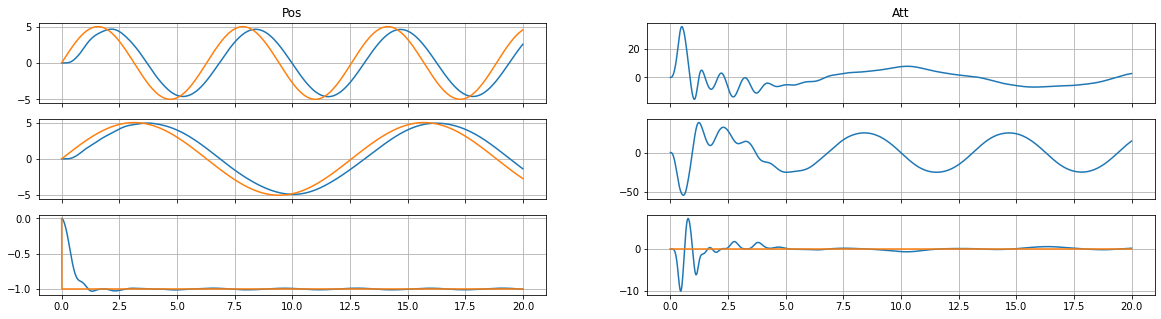

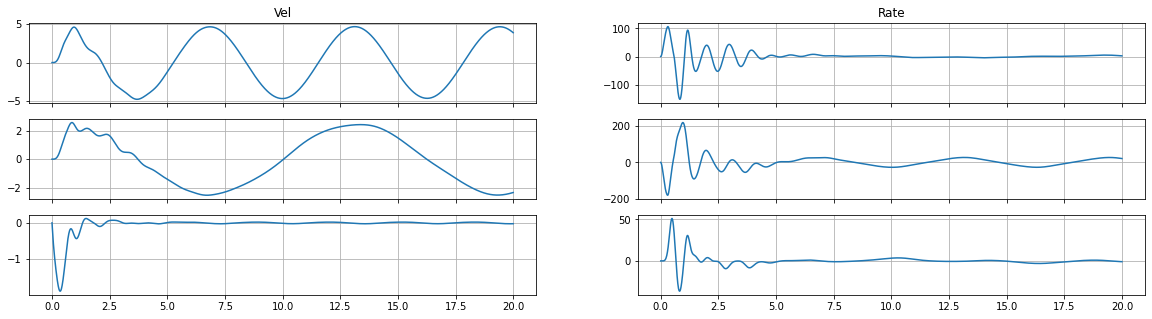

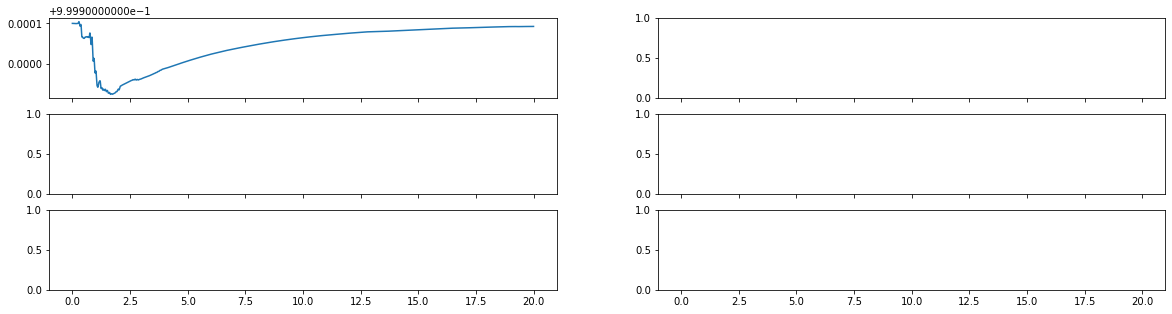

In [42]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

fig,ax = plt.subplots(3,2, sharex=True)
for i in range(3):
    ax[i,0].plot(t, pos[i])
    ax[i,0].plot(t, ref_pos[i])
    
    ax[i,1].plot(t, np.rad2deg(eul[i]))
    ax[i,1].plot(t, np.rad2deg(ref_att[i]))

[ ax[i,j].grid() for i in range(3) for j in range(2) ]
ax[0,0].set_title('Pos')
ax[0,1].set_title('Att')
        
fig,ax = plt.subplots(3,2, sharex=True)
for i in range(3):
    ax[i,0].plot(t, vel[i])
    ax[i,0].plot(t, ref_vel[i])
    
    ax[i,1].plot(t, np.rad2deg(rate[i]))
    ax[i,1].plot(t, np.rad2deg(ref_rate[i]))
    # ax[i,3].plot(time, LMN[i])
    
[ ax[i,j].grid() for i in range(3) for j in range(2) ]
ax[0,0].set_title('Vel')
ax[0,1].set_title('Rate')

# # Plot quaternion components q0 .. q3
# fig,ax = plt.subplots(4, sharex=True)
# for i in range(4):
#     ax[i].plot(t, att[i])

fig,ax = plt.subplots(3,2, sharex=True)
ax[0,0].plot(t, LA.norm(att, axis=0))

**Visualise**

In [38]:
def create_quadcopter(vis):
    arm_length = 0.25
    rotor_radius = 0.125

    # Arms
    vis['drone']['left_arm'].set_object(g.Box([2*arm_length, 0.05, 0.05]))
    vis['drone']['left_arm'].set_transform(tf.rotation_matrix(np.deg2rad(45), [0,0,1]))
    vis['drone']['right_arm'].set_object(g.Box([2*arm_length, 0.05, 0.05]))
    vis['drone']['right_arm'].set_transform(tf.rotation_matrix(np.deg2rad(-45), [0,0,1]))

    # Rotors
    for i in range(1,5):
        theta = np.deg2rad(45 + 90*i)
        offset = np.array([arm_length * np.sin(theta), arm_length * np.cos(theta), 0.05])

        # Compute transformation
        T = tf.rotation_matrix(np.deg2rad(90), [1,0,0])
        T[0:3,3] = offset

        vis['drone'][f'rotor{i}'].set_object(g.Cylinder(0.01, rotor_radius))
        vis['drone'][f'rotor{i}'].set_transform(T)
        
    return vis['drone']

vis.delete()
drone = create_quadcopter(vis)

# Set camera
T = tf.rotation_matrix(np.deg2rad(45), [0,0,1])
T[0:3,3] = [3,3,2]
vis['/Cameras'].set_transform(T)

vis.jupyter_cell()

In [43]:
for i in range(ref.shape[1]):
    # Convert NED to ENU
    pos_enu = np.array([1,-1,-1]) * pos[:,i]
    att_enu = np.array([1,-1,-1]) * eul[:,i]
    
    # Form homogeneous transformation
    T = tf.euler_matrix(*att_enu)
    T[0:3,3] = pos_enu
    
    # Apply
    vis.set_transform(T)
    time.sleep(0.001)